#  基于PaddleX-YoloV3检测装甲板实现自瞄 


## 项目背景简介

> 全国大学生机器人大赛RoboMaster 机甲大师对抗赛，侧重参赛队员对理工学科的综合应用与工程实践能力，充分融合了“机器视觉”、“嵌入式系统设计”、“机械控制”、“惯性导航”、“人机交互”等众多机器人相关技术学科，同时创新性的将电竞呈现方式与机器人竞技相结合，使机器人对抗更加直观激烈，吸引众多的科技爱好者与社会公众的广泛关注和参与。
 
 该项目使用**PaddleX**提供的YOLOv3模型检测装甲板实现自瞄 

## 目录：
0. 解压数据集unzip；
1. 安装PaddleX；
2. 准备装甲板数据集；
3. 生成训练所需文件；
4. 设置图像数据预处理和数据增强模块；
5. 读取数据集；
6. 定义模型并开始训练；
7. 评估模型性能；
8. 保存模型；
9. 总结

## 最终效果：

![al3ZiF.jpg](https://s1.ax1x.com/2020/07/31/al3ZiF.jpg)
![al3kZV.jpg](https://s1.ax1x.com/2020/07/31/al3kZV.jpg)
![al3EIU.jpg](https://s1.ax1x.com/2020/07/31/al3EIU.jpg)
![al3iq0.jpg](https://s1.ax1x.com/2020/07/31/al3iq0.jpg)

### 本文作者为重庆三峡学院LionHeart战队顾问**马云飞**
### 感谢 [宋迪老师](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/31756) 以及 [BIT可达鸭](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/67156) 的指导


## 0. 解压数据集unzip（只需运行一次）

In [ ]:
!unzip /home/aistudio/data/data46309/rmcvdata.zip -d /home/aistudio/work/rmcvdata/

## 1. 安装PaddleX

In [1]:
!pip install pycocotools
!pip install lxml
!pip install paddlex -i https://mirror.baidu.com/pypi/simple

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
  Created wheel for pycocotools: filename=pycocotools-2.0.1-cp37-cp37m-linux_x86_64.whl size=286592 sha256=8fa5ac4013524360c3dd31a5d8c80e8f4a198c1e8211e0eb1ca4b8d5b9572187
  Stored in directory: /home/aistudio/.cache/pip/wheels/e6/31/94/6fdc420ae47d5bb8374d12b153be59ab82f4a9b20c9248cd81
Successfully built pycocotools
     |████████████████████████████████| 5.5MB 39.5MB/s eta 0:00:01�██████▌      | 4.4MB 39.5MB/s eta 0:00:01
Looking in indexes: https://mirror.baidu.com/pypi/simple
     |████████████████████████████████| 286kB 15.3MB/s eta 0:00:01
     |████████████████████████████████| 337kB 12.0MB/s eta 0:00:01
     |████████████████████████████████| 112kB 30.6MB/s eta 0:00:01
  Found existing installation: paddlehub 1.6.0
    Uninstalling paddlehub-1.6.0:
      Successfully uninstalled paddlehub-1.6.0


## 2. 准备装甲板数据集
我们使用的数据集是 [大连理工大学0bug战队视觉组](https://bbs.robomaster.com/thread-10814-1-1.html) 分享的COCO格式数据

我们先将它转换为VOC格式

In [ ]:
from pycocotools.coco import COCO
import os, cv2, shutil
from lxml import etree, objectify
from tqdm import tqdm
from PIL import Image
 
CKimg_dir = 'work/rmcvdata/VOC/images'
CKanno_dir = 'work/rmcvdata/VOC/annotations'
 
 
# 若模型保存文件夹不存在，创建模型保存文件夹，若存在，删除重建
def mkr(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        os.makedirs(path)
    else:
        os.makedirs(path)
 
 
def save_annotations(filename, objs, filepath):
    annopath = CKanno_dir + "/" + filename[:-3] + "xml"  # 生成的xml文件保存路径
    dst_path = CKimg_dir + "/" + filename
    img_path = filepath
    img = cv2.imread(img_path)
    im = Image.open(img_path)
    if im.mode != "RGB":
        print(filename + " not a RGB image")
        im.close()
        return
    im.close()
    shutil.copy(img_path, dst_path)  # 把原始图像复制到目标文件夹
    E = objectify.ElementMaker(annotate=False)
    anno_tree = E.annotation(
        E.folder('1'),
        E.filename(filename),
        E.source(
            E.database('CKdemo'),
            E.annotation('VOC'),
            E.image('CK')
        ),
        E.size(
            E.width(img.shape[1]),
            E.height(img.shape[0]),
            E.depth(img.shape[2])
        ),
        E.segmented(0)
    )
    for obj in objs:
        E2 = objectify.ElementMaker(annotate=False)
        anno_tree2 = E2.object(
            E.name(obj[0]),
            E.pose(),
            E.truncated("0"),
            E.difficult(0),
            E.bndbox(
                E.xmin(obj[2]),
                E.ymin(obj[3]),
                E.xmax(obj[4]),
                E.ymax(obj[5])
            )
        )
        anno_tree.append(anno_tree2)
    etree.ElementTree(anno_tree).write(annopath, pretty_print=True)
 
 
def showbycv(coco, dataType, img, classes, origin_image_dir, verbose=False):
    filename = img['file_name']
    filepath = os.path.join(origin_image_dir, dataType, filename)
    I = cv2.imread(filepath)
    annIds = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)
    objs = []
    for ann in anns:
        name = classes[ann['category_id']]
        if 'bbox' in ann:
            bbox = ann['bbox']
            xmin = (int)(bbox[0])
            ymin = (int)(bbox[1])
            xmax = (int)(bbox[2] + bbox[0])
            ymax = (int)(bbox[3] + bbox[1])
            obj = [name, 1.0, xmin, ymin, xmax, ymax]
            objs.append(obj)
            if verbose:
                cv2.rectangle(I, (xmin, ymin), (xmax, ymax), (255, 0, 0))
                cv2.putText(I, name, (xmin, ymin), 3, 1, (0, 0, 255))
    save_annotations(filename, objs, filepath)
    if verbose:
        cv2.imshow("img", I)
        cv2.waitKey(0)

def catid2name(coco):  # 将名字和id号建立一个字典
    classes = dict()
    for cat in coco.dataset['categories']:
        classes[cat['id']] = cat['name']
        # print(str(cat['id'])+":"+cat['name'])
    return classes
 
 
def get_CK5(origin_anno_dir, origin_image_dir, verbose=False):
    dataTypes = ['roco_train', 'roco_val']
    for dataType in dataTypes:
        annFile = '{}.json'.format(dataType)
        annpath = os.path.join(origin_anno_dir, annFile)
        coco = COCO(annpath)
        classes = catid2name(coco)
        imgIds = coco.getImgIds()
        # imgIds=imgIds[0:1000]#测试用，抽取10张图片，看下存储效果
        for imgId in tqdm(imgIds):
            img = coco.loadImgs(imgId)[0]
            showbycv(coco, dataType, img, classes, origin_image_dir, verbose=False)
 
 
def main():
    base_dir = 'work/rmcvdata/VOC'  # step1 这里是一个新的文件夹，存放转换后的图片和标注
    image_dir = os.path.join(base_dir, 'images')  # 在上述文件夹中生成images，annotations两个子文件夹
    anno_dir = os.path.join(base_dir, 'annotations')
    mkr(image_dir)
    mkr(anno_dir)
    origin_image_dir = 'work/rmcvdata'  # step 2原始的coco的图像存放位置
    origin_anno_dir = 'work/rmcvdata'  # step 3 原始的coco的标注存放位置
    verbose = False  # 是否需要看下标记是否正确的开关标记，若是true,就会把标记展示到图片上
    get_CK5(origin_anno_dir, origin_image_dir, verbose)
 
 
if __name__ == "__main__":
    main()

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/
loading annotations into memory...
Done (t=4.32s)
creating index...
index created!


100%|██████████| 96953/96953 [05:36<00:00, 288.29it/s]


loading annotations into memory...
Done (t=0.19s)
creating index...
index created!


100%|██████████| 10596/10596 [00:38<00:00, 276.38it/s]


## 3. 生成训练所需文件

In [ ]:
import os
import random
import sys
from tqdm import tqdm


root_path = 'work/rmcvdata/VOC'

xmlfilepath = root_path + '/annotations'

txtsavepath = root_path 

if not os.path.exists(root_path):
    print("cannot find such directory: " + root_path)
    exit()

if not os.path.exists(txtsavepath):
    os.makedirs(txtsavepath)

trainval_percent = 0.9
train_percent = 0.8
total_xml = os.listdir(xmlfilepath)[:12000]
num = len(total_xml)
list = range(num)
tv = int(num * trainval_percent)
tr = int(tv * train_percent)
trainval = random.sample(list, tv)
train = random.sample(trainval, tr)

print("train and val size:", tv)
print("train size:", tr)

ftrainval = open(txtsavepath + '/trainval.txt', 'w')
ftest = open(txtsavepath + '/test.txt', 'w')
ftrain = open(txtsavepath + '/train_list.txt', 'w')
fval = open(txtsavepath + '/val_list.txt', 'w')

for i in tqdm(range(num)):
    name = total_xml[i][:-4] 
    if i in trainval:
        ftrainval.write(name)
        if i in train:
            ftrain.write('images/' + name + '.jpg annotations/' + name + '.xml' + '\n')
        else:
            fval.write('images/' + name + '.jpg annotations/' + name + '.xml' + '\n')
    else:
        ftest.write(name)

ftrainval.close()
ftrain.close()
fval.close()
ftest.close()


 13%|█▎        | 1606/12000 [00:00<00:01, 8110.09it/s]

train and val size: 10800
train size: 8640


 19%|█▉        | 2305/12000 [00:00<00:01, 7734.98it/s]100%|██████████| 12000/12000 [00:01<00:00, 6273.22it/s]


## 4. 设置图像数据预处理和数据增强模块

In [2]:
# 设置使用0号GPU卡（如无GPU，执行此代码后仍然会使用CPU训练模型）
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import paddlex as pdx


from paddlex.det import transforms
train_transforms = transforms.Compose([
    transforms.MixupImage(mixup_epoch=250),
    transforms.RandomDistort(),
    transforms.RandomExpand(),
    transforms.RandomCrop(),
    transforms.Resize(target_size=608, interp='RANDOM'),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize(),
])

eval_transforms = transforms.Compose([
    transforms.Resize(target_size=608, interp='CUBIC'),
    transforms.Normalize(),
])


## 5. 读取数据集

> ### 参数说明：

* **data_dir (str)**: 数据集所在的目录路径。

* **file_list (str)**: 描述数据集图片文件和对应标注文件的文件路径（文本内每行路径为相对data_dir的相对路径）。

* **label_list (str)**: 描述数据集包含的类别信息文件路径。

* **transforms (paddlex.det.transforms)**: 数据集中每个样本的预处理/增强算子，详见paddlex.det.transforms。

* **num_workers (int|str)**：数据集中样本在预处理过程中的线程或进程数。默认为’auto’。当设为’auto’时，根据系统的实际CPU核数设置num_workers: 如果CPU核数的一半大于8，则num_workers为8，否则为CPU核数的一半。

* **buffer_size (int)**: 数据集中样本在预处理过程中队列的缓存长度，以样本数为单位。默认为100。

* **parallel_method (str)**: 数据集中样本在预处理过程中并行处理的方式，支持’thread’线程和’process’进程两种方式。默认为’thread’（Windows和Mac下会强制使用thread，该参数无效）。

* **shuffle (bool)**: 是否需要对数据集中样本打乱顺序。默认为False。

In [4]:


with open('work/rmcvdata/VOC/labels.txt', 'w') as f:
    for v in ['armor_blue', 'armor_red']:
        f.write(v+'\n')

datadir = 'work/rmcvdata/VOC'

train_dataset = pdx.datasets.VOCDetection(
    data_dir= datadir,
    file_list= datadir + '/train_list.txt',
    label_list= datadir + '/labels.txt',
    transforms=train_transforms,
    shuffle=True)
eval_dataset = pdx.datasets.VOCDetection(
    data_dir= datadir ,
    file_list= datadir + '/val_list.txt',
    label_list= datadir + '/labels.txt',
    transforms=eval_transforms)

2020-08-10 21:47:04,478-INFO: font search path ['/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/afm', '/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2020-08-10 21:47:04,830-INFO: generated new fontManager


2020-08-10 21:47:04 [INFO]	Starting to read file list from dataset...
2020-08-10 21:47:46 [INFO]	16826 samples in file work/rmcvdata/VOC/train_list.txt
creating index...
index created!
2020-08-10 21:47:46 [INFO]	Starting to read file list from dataset...
2020-08-10 21:47:57 [INFO]	4117 samples in file work/rmcvdata/VOC/val_list.txt
creating index...
index created!


## 6. 定义模型并开始训练

本文使用DarkNet53作为backbone

> ### 参数说明：  
* **num_classes (int)**: 类别数。默认为80。
* **backbone (str)**: YOLOv3的backbone网络，取值范围为[‘DarkNet53’, ‘ResNet34’, ‘MobileNetV1’, ‘MobileNetV3_large’]。默认为’MobileNetV1’。
* **anchors (list|tuple)**: anchor框的宽度和高度，为None时表示使用默认值 [[10, 13], [16, 30], [33, 23], [30, 61], [62, 45], [59, 119], [116, 90], [156, 198], [373, 326]]。
* **anchor_masks (list|tuple)**: 在计算YOLOv3损失时，使用anchor的mask索引，为None时表示使用默认值 [[6, 7, 8], [3, 4, 5], [0, 1, 2]]。
* **ignore_threshold (float)**: 在计算YOLOv3损失时，IoU大于ignore_threshold的预测框的置信度被忽略。默认为0.7。
* **nms_score_threshold (float)**: 检测框的置信度得分阈值，置信度得分低于阈值的框应该被忽略。默认为0.01。
* **nms_topk (int)**: 进行NMS时，根据置信度保留的最大检测框数。默认为1000。
* **nms_keep_topk (int)**: 进行NMS后，每个图像要保留的总检测框数。默认为100。
* **nms_iou_threshold (float)**: 进行NMS时，用于剔除检测框IOU的阈值。默认为0.45。
* **label_smooth (bool)**: 是否使用label smooth。默认值为False。
* **train_random_shapes (list|tuple)**: 训练时从列表中随机选择图像大小。默认值为[320, 352, 384, 416, 448, 480, 512, 544, 576, 608]。

In [5]:
net='DarkNet53'

num_classes = len(train_dataset.labels)
model = pdx.det.YOLOv3(num_classes=num_classes, backbone=net)
model.train(
    num_epochs=4,
    train_dataset=train_dataset,
    train_batch_size=8,
    eval_dataset=eval_dataset,
    learning_rate=0.000125,
    save_interval_epochs=2,
    save_dir='output/' + net,
    pretrain_weights='IMAGENET'
)

2020-08-10 22:10:06,743-INFO: If regularizer of a Parameter has been set by 'fluid.ParamAttr' or 'fluid.WeightNormParamAttr' already. The Regularization[L2Decay, regularization_coeff=0.000500] in Optimizer will not take effect, and it will only be applied to other Parameters!


2020-08-10 22:10:08 [INFO]	Connecting PaddleHub server to get pretrain weights...
2020-08-10 22:10:11 [INFO]	Load pretrain weights from output/DarkNet53/pretrain/DarkNet53.


2020-08-10 22:10:11,138-WARNING: output/DarkNet53/pretrain/DarkNet53.pdparams not found, try to load model file saved with [ save_params, save_persistables, save_vars ]


100%|██████████| 515/515 [01:59<00:00,  4.32it/s]


100%|██████████| 515/515 [02:07<00:00,  4.05it/s]


2020-08-10 23:01:31 [INFO]	[EVAL] Finished, Epoch=4, bbox_map=89.050858 .
2020-08-10 23:01:42 [INFO]	Model saved in output/DarkNet53/best_model.
2020-08-10 23:01:49 [INFO]	Model saved in output/DarkNet53/epoch_4.
2020-08-10 23:01:49 [INFO]	Current evaluated best model in eval_dataset is epoch_4, bbox_map=89.05085804908445


## 7. 评估模型性能

In [6]:
model.evaluate(eval_dataset, batch_size=1, epoch_id=None, metric=None, return_details=False)

2020-08-10 23:55:49 [INFO]	Start to evaluating(total_samples=4117, total_steps=4117)...


100%|██████████| 4117/4117 [05:52<00:00, 11.67it/s]


OrderedDict([('bbox_map', 89.05085804908445)])

In [ ]:
model = pdx.load_model('output/DarkNet53/best_model/')

2020-08-03 10:54:16 [INFO]	Model[YOLOv3] loaded.


infer time:0.123004s
detected num: 10


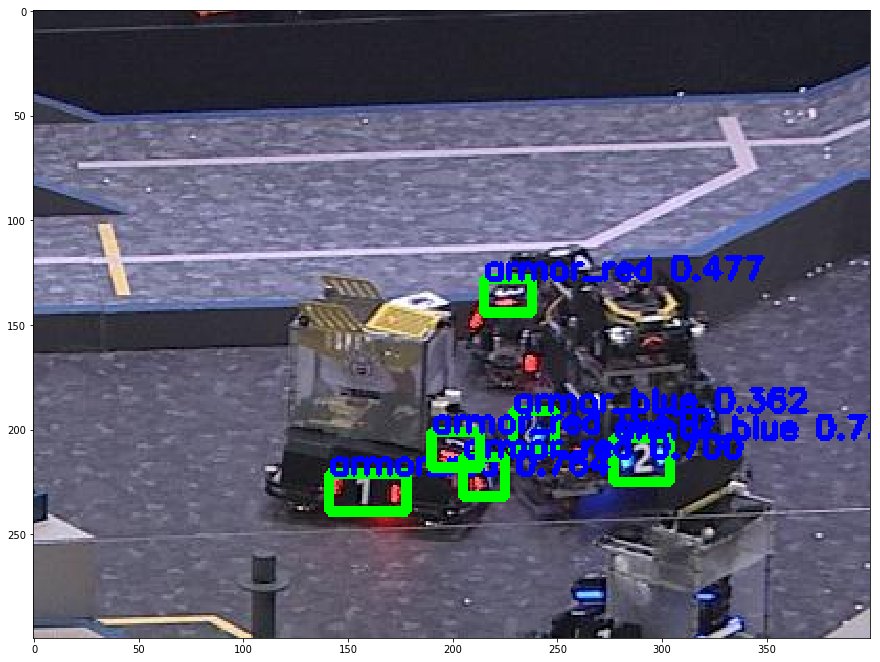

In [8]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

image_name = 'work/rmcvdata/roco_train/00000019.jpg'
start = time.time()
result = model.predict(image_name, eval_transforms)
print('infer time:{:.6f}s'.format(time.time()-start))
print('detected num:', len(result))

im = cv2.imread(image_name)
font = cv2.FONT_HERSHEY_SIMPLEX
threshold = 0.1

for value in result:
    xmin, ymin, w, h = np.array(value['bbox']).astype(np.int)
    cls = value['category']
    score = value['score']
    if score < threshold:
        continue
    cv2.rectangle(im, (xmin, ymin), (xmin+w, ymin+h), (0, 255, 0), 4)
    cv2.putText(im, '{:s} {:.3f}'.format(cls, score),
                    (xmin, ymin), font, 0.5, (255, 0, 0), thickness=2)

cv2.imwrite('result.jpg', im)
plt.figure(figsize=(15,12))
plt.imshow(im[:, :, [2,1,0]])
plt.show()

## 8. 保存模型

In [ ]:
model.save_model('darknet53-model')

2020-08-03 10:53:18 [INFO]	Model saved in darknet53-model.


## 9. 总结

> 1. 本文使用了PaddleX-YoloV3在装甲板数据集上进行了训练
> 2. 使用训练好的YOLOv3模型进行装甲板的检测

## 关于作者

> ## 马云飞 
> 枣庄学院 地理信息科学专业 大二在读  
> 山东数据庄园网络科技有限公司 技术总监  
> 重庆三峡学院LionHeart战队 顾问  
> 感兴趣的方向为：神经网络在遥感领域的应用 等  

> GitHub: <https://github.com/heiheiheiheiheihei>  
> CSDN: <https://me.csdn.net/qq_23305385>  
> bilibili: <https://space.bilibili.com/137012734>  
> kaggle: <https://www.kaggle.com/heiheihei2017>  
![aHNC0U.gif](https://s1.ax1x.com/2020/08/10/aHNC0U.gif)
 
### 感谢 [学习委员](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/31756) 以及 [BIT可达鸭](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/67156) 的指导